In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from datetime import datetime, timedelta
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from scipy import stats
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
test = pd.read_csv('/content/drive/MyDrive/Apartment_Data/test.csv')
train = pd.read_csv('/content/drive/MyDrive/Apartment_Data/train.csv')
sub = pd.read_csv('/content/drive/MyDrive/Apartment_Data/sample_submission.csv')

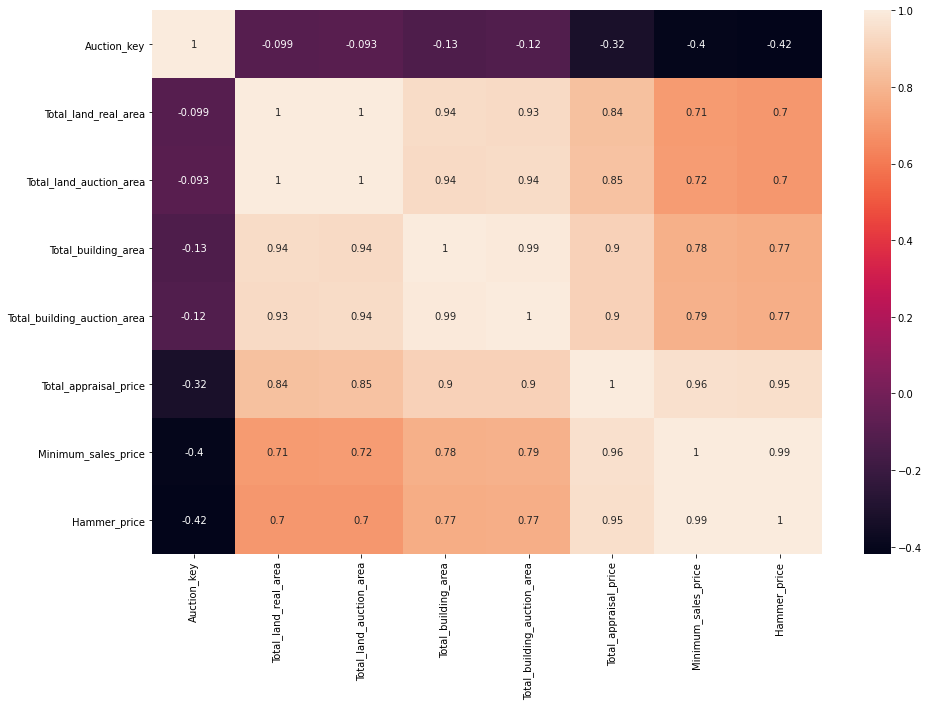

In [ ]:
cor = train.corr()
cor_fe = cor.index[abs(cor['Hammer_price']) >= 0.3]
plt.figure(figsize=(15,10))
sns.heatmap(train[cor_fe].corr(),annot=True)

In [ ]:
def scatter_print(features):
  var = features
  var_data = pd.concat([train['Hammer_price'], train[var]], axis=1)
  var_data.plot.scatter(x=var, y='Hammer_price', ylim=(0, 151.51))
  plt.show()

In [2]:
for i in train:
  scatter_print(i)

NameError: ignored

In [ ]:
train['Temporary_price'] = train['Hammer_price'] / train['Minimum_sales_price']

In [ ]:
#### 2020-12-01
## Auction_real_count =  Auction_count - Auction_miscarriage_count
train['Auction_real_count'] = train['Auction_count'] - train['Auction_miscarriage_count']
test['Auction_real_count'] = test['Auction_count'] - test['Auction_miscarriage_count']

In [ ]:
#### 2020-11-29 Apartment_real_area = Total_building_area / Total_floor
train['Apartment_real_area'] = train['Total_building_area'] / train['Total_floor']
test['Apartment_real_area'] = test['Total_building_area'] / test['Total_floor']
## Price_per_meter = 각 구의 모든 Hammer_price / 모든 Apartment_real_area 의 평균 => 단위 미터당 가격 
## market_price = Price_per_meter(각 구에 대한 땅값의 평균) * Apartment_real_area
addr_si_price = {'영도구':0, '용산구':0, '동래구':0, '관악구':0, '서구':0, '사상구':0, '동작구':0, '동구':0, '강북구':0, '남구':0, '종로구':0, 
             '은평구':0, '중구':0, '마포구':0, '금정구':0, '서대문구':0, '연제구':0, '강서구':0, '사하구':0, '노원구':0, '기장군':0, '광진구':0, 
             '수영구':0, '성북구':0, '부산진구':0, '양천구':0, '성동구':0, '구로구':0, '도봉구':0, '영등포구':0, '강남구':0, '동대문구':0, '중랑구':0, 
             '서초구':0, '강동구':0, '북구':0, '금천구':0, '송파구':0, '해운대구':0}
for i in range(train.shape[0]):
  if addr_si_price[train['addr_si'][i]] == 0:
    addr_si_price[train['addr_si'][i]] = train['Hammer_price'][i] / train['Apartment_real_area'][i] 
  else:
    addr_si_price[train['addr_si'][i]] += train['Hammer_price'][i] / train['Apartment_real_area'][i] 
    addr_si_price[train['addr_si'][i]] /= 2


# 2020-11-30 원래 Market_price를 Market_price_per_meter로 변환 
# Market_price_per_meter 추가 후 확인 -> 결과 의미 없음
# => Market_price가 실제 Hammer_price와 유사하지 않음 구로 할 경우 가격 차이가 많이 나는거 같음
train['Market_price'] = 0.0
train['Market_price_per_meter'] = 0.0
for i in range(train.shape[0]):
  train['Market_price_per_meter'][i] = addr_si_price[train['addr_si'][i]]
  train['Market_price'][i] = addr_si_price[train['addr_si'][i]] * train['Apartment_real_area'][i]
test['Market_price'] = 0.0
test['Market_price_per_meter'] = 0.0
for i in range(test.shape[0]):
  test['Market_price_per_meter'][i] = addr_si_price[test['addr_si'][i]]
  test['Market_price'][i] = addr_si_price[test['addr_si'][i]] * test['Apartment_real_area'][i]

train.head(500)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to b

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,First_auction_date,Final_auction_date,Final_result,Creditor,addr_do,addr_si,addr_dong,addr_li,addr_san,addr_bunji1,addr_bunji2,addr_etc,Apartment_usage,Preserve_regist_date,Total_floor,Current_floor,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Hammer_price,Temporary_price,Auction_real_count,Apartment_real_area,Market_price,Market_price_per_meter
0,2687,임의,개별,17.660373,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,37.35,181.77,181.77,8.360000,6.68800,2018-02-13 00:00:00,2018-03-20 00:00:00,낙찰,베리타스자산관리대부,부산,해운대구,우동,NaN,N,1398.0,NaN,해운대엑소디움 5층 101-502호,Apartment & Stores,2009-07-14 00:00:00,45,5,NaN,N,해운대해변로,30.0,NaN,2018-06-14 00:00:00,배당,35.162717,129.137048,7.600000,1.136364,1,4.039333,3.293153,0.815271
1,2577,임의,일반,1.529469,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,18.76,118.38,118.38,10.730000,8.58400,2016-12-29 00:00:00,2017-02-02 00:00:00,낙찰,흥국저축은행,부산,해운대구,우동,NaN,N,1407.0,NaN,해운대두산위브더제니스 103동 51층 5103호,Apartment,2011-12-16 00:00:00,70,51,NaN,N,마린시티2로,33.0,NaN,2017-03-30 00:00:00,배당,35.156633,129.145068,9.718900,1.132211,1,1.691143,1.378740,0.815271
2,2197,임의,개별,0.113265,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,71.00,49.94,49.94,1.190000,0.76160,2017-07-28 00:00:00,2017-10-13 00:00:00,낙찰,국민은행,부산,사상구,모라동,NaN,N,552.0,NaN,백양그린 206동 14층 1403호,Apartment,1992-07-31 00:00:00,15,14,NaN,N,모라로110번길,88.0,NaN,2017-12-13 00:00:00,배당,35.184601,128.996765,0.934000,1.226366,1,3.329333,1.129546,0.339271
3,2642,임의,일반,1.835817,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,32.98,84.91,84.91,2.884000,2.30720,2017-07-20 00:00:00,2017-11-02 00:00:00,낙찰,고려저축은행,부산,남구,대연동,NaN,N,243.0,23.0,대연청구 109동 11층 1102호,Apartment,2001-07-13 00:00:00,20,11,NaN,N,황령대로319번가길,110.0,NaN,2017-12-27 00:00:00,배당,35.154180,129.089081,2.568990,1.113467,1,4.245500,3.324386,0.783038
4,1958,강제,일반,0.458877,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,45.18,84.96,84.96,1.700000,1.36000,2016-07-06 00:00:00,2016-08-03 00:00:00,낙찰,Private,부산,사하구,괴정동,NaN,N,399.0,2.0,동조리젠시 7층 703호,Apartment,2001-11-27 00:00:00,7,7,NaN,N,오작로,51.0,NaN,2016-10-04 00:00:00,배당,35.099630,128.998874,1.586600,1.166618,1,12.137143,1.948405,0.160532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2492,강제,일반,0.033430,대우감정,2016-03-15 00:00:00,3,2,2004.0,20.87,20.87,39.67,39.67,0.560000,0.35840,2016-06-27 00:00:00,2016-08-22 00:00:00,낙찰,엠메이드대부,부산,남구,문현동,NaN,N,1087.0,NaN,범일 2동 1층 11258호,Apartment,1971-09-30 00:00:00,4,1,NaN,N,장고개로85번가길,30.0,NaN,2016-10-25 00:00:00,배당,35.130758,129.068520,0.424199,1.183591,1,9.917500,7.765775,0.783038
496,1776,강제,개별,10.870000,대한감정,2012-06-11 00:00:00,5,3,532.0,16.65,16.65,98.08,98.08,2.187456,1.11998,2013-07-04 00:00:00,2016-04-29 00:00:00,낙찰,Private,부산,동래구,낙민동,NaN,N,236.0,NaN,",237-2 삼주 4층 401호",Apartment & Stores,1111-11-11 00:00:00,15,4,"**1차감정:210,000,000",N,0,NaN,NaN,2017-06-29 00:00:00,배당,35.201112,129.088687,1.178000,1.051804,2,6.538667,2.316399,0.354262
497,1848,임의,일반,1.920000,가람감정,2015-11-10 00:00:00,2,1,24385.0,71.74,71.74,125.50,125.50,2.800000,2.24000,2016-04-05 00:00:00,2016-05-03 00:00:00,낙찰,신한은행,부산,사하구,당리동,NaN,N,16.0,7.0,1차동원베네스트 106동 5층 502호,Apartment,2005-12-28 00:00:00,13,5,NaN,N,제석로,160.0,NaN,2016-06-30 00:00:00,배당,35.109728,128.983244,2.595000,1.158482,1,9.653846,1.549755,0.160532
498,2343,강제,일반,0.330409,가람감정,2017-01-31 00:00:00,2,1,146268.8,52.00,52.00,58.46,58.46,1.360000,1.08800,2017-11-02 00:00:00,2017-12-07 00:00:00,낙찰,부산신용보증재단,부산,영도구,동삼동,NaN,N,1123.0,NaN,동삼그린힐 301동 5층 502호,Apartment,1993-10-22 00:00:00,15,5,NaN,N,상리로,1.0,NaN,2018-02-26 00:00:00,배당,35.086226,129.068529,1.211500,1.113511,1,3

In [ ]:
for i in range(train.shape[0]):
  if train['addr_si'][i] == '영도구':
    print(i, train['addr_dong'][i], train['Hammer_price'][i], train['Market_price_per_meter'][i],  " Each_Market_price_dong : ", train['Hammer_price'][i] / train['Apartment_real_area'][i])

5 청학동 2.06989 0.20828859014333873  Each_Market_price_dong :  0.49014681506038366
6 동삼동 1.355 0.20828859014333873  Each_Market_price_dong :  0.07213842058562554
11 동삼동 2.210172 0.20828859014333873  Each_Market_price_dong :  0.39131940509915014
18 동삼동 1.2665110000000002 0.20828859014333873  Each_Market_price_dong :  0.13595657204198475
21 봉래동4가 0.6029899999999999 0.20828859014333873  Each_Market_price_dong :  0.10051508584764125
40 청학동 1.97555 0.20828859014333873  Each_Market_price_dong :  0.4649994115570201
47 동삼동 0.9439 0.20828859014333873  Each_Market_price_dong :  0.08764159702878366
52 대교동1가 4.15 0.20828859014333873  Each_Market_price_dong :  0.6060163551401869
89 청학동 1.39999999 0.20828859014333873  Each_Market_price_dong :  0.46690011339002835
106 동삼동 1.0215100000000001 0.20828859014333873  Each_Market_price_dong :  0.3068211854225071
111 동삼동 1.85899999 0.20828859014333873  Each_Market_price_dong :  0.32515158407182837
225 동삼동 1.487511 0.20828859014333873  Each_Market_price_dong : 

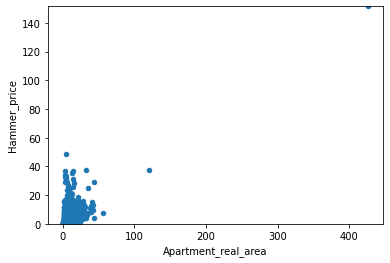

In [ ]:
scatter_print('Apartment_real_area')

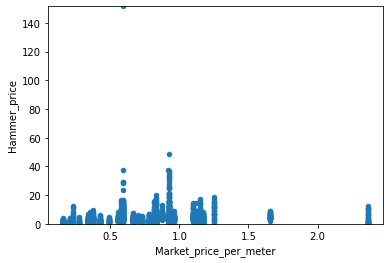

In [ ]:
scatter_print('Market_price_per_meter')

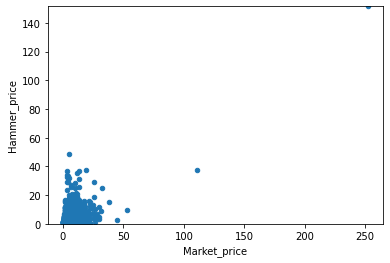

In [ ]:
scatter_print('Market_price') 

In [ ]:
#### 2020-11-27 중간층수 가격 높음

## http://www.kahps.org/data/_research/201905/15593089066584.pdf
## 13층 이상일 경우 7-9 층이 가격이 높은 것으로 나옴 => 8층
## 7층 - 12층 4-6층 => 5층
## 6층 이하 Top - 1
train['Loyal_floor'] = 0.0
for i in range(train.shape[0]):
  if abs((train['Total_floor'][i] / 2) - train['Current_floor'][i]) == 0:
    train['Loyal_floor'][i] = 1
  else: train['Loyal_floor'][i] = ((train['Total_floor'][i] / 2) - abs((train['Total_floor'][i] / 2) - train['Current_floor'][i])) / (train['Total_floor'][i] / 2) 

test['Loyal_floor'] = 0.0
for i in range(test.shape[0]):
  if abs((test['Total_floor'][i] / 2) - test['Current_floor'][i]) == 0:
    test['Loyal_floor'][i] = 1
  else: test['Loyal_floor'][i] = ((test['Total_floor'][i] / 2) - abs((test['Total_floor'][i] / 2) - test['Current_floor'][i])) / (test['Total_floor'][i] / 2) 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


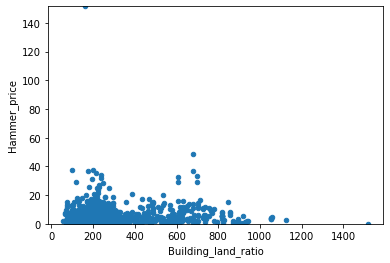

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
## 건폐율 계산 - 학습 시 정확도 떨어짐
train['Building_land_ratio'] = 0
for i in range(train.shape[0]):
  if train['Total_land_real_area'][i] != 0:
    train['Building_land_ratio'][i] = train['Total_building_area'][i] / train['Total_land_real_area'][i] * 100
  else: train['Building_land_ratio'][i] = 100
scatter_print('Building_land_ratio') 

test['Building_land_ratio'] = 0
for i in range(test.shape[0]):
  if test['Total_land_real_area'][i] != 0:
    test['Building_land_ratio'][i] = test['Total_building_area'][i] / test['Total_land_real_area'][i] * 100
  else: test['Building_land_ratio'][i] = 100

In [ ]:

# 아파트 연령 : First_auction_date - Preserve_regist_date => Apartment_age = First_auction_date - Preserve_regist_date

# 결측치 생각하기 1111-11-11, 0000-00-00
# 결측치 평균값, 표준값, 최빈값 들로 대체 해야 함 => 각 동들의 평균으로 대체
# 결측치 부터 찾아야 됨. Pandas 이용
# train.fillna 로 결측값 채우기 -> na가 아니기 때문에 임의로 평균값 구하고 채우기

# 대체한 후에 First - Preserve 두 개로 Apartment_age 추가
# 년도?? Fisrt에 연도만 빼오고 - Preserve 연도
# 일수로 한다면 year * 360 + month * 30 + day
# ==> columns에 => Apartment_age 추가
# ====> 최종 datetime module 사용 


############################################## 구현
## 1111-11-11 00:00:00일 때 Auction_key들을 반환
## df에는 train, test 들, feaures에는 First_auction_date, Final, Preserve 값들이 들어감
## find_missing_data 함수, Data Frame, feature을 매개변수로 받음
## 1111-11-11 00:00:00 일 경우 해당 row의 Auction_key 값을 missing_date_id로 저장
## missing_date_id 출력
def find_missing_date(df, features):
  missing_date_id = []
  for i in range(df.shape[0]):
    if df[features][i] == '1111-11-11 00:00:00':
      missing_date_id.append(df['Auction_key'][i])
  return missing_date_id


## 평균 구하기
## addr_si로 구분한 후 features에 해당하는 평균 날짜 구하기
## missingid일 경우 평균 안 구함
## 처음 for => 평균 구하기, 두번째 for -> 평균 값 넣기, type을 datetime으로 바꾸기
def predict_missing_date_with_dong(df, features, missing_date_id):
  addr_si_mean = {'영도구':0, '용산구':0, '동래구':0, '관악구':0, '서구':0, '사상구':0, '동작구':0, '동구':0, '강북구':0, '남구':0, '종로구':0, 
             '은평구':0, '중구':0, '마포구':0, '금정구':0, '서대문구':0, '연제구':0, '강서구':0, '사하구':0, '노원구':0, '기장군':0, '광진구':0, 
             '수영구':0, '성북구':0, '부산진구':0, '양천구':0, '성동구':0, '구로구':0, '도봉구':0, '영등포구':0, '강남구':0, '동대문구':0, '중랑구':0, 
             '서초구':0, '강동구':0, '북구':0, '금천구':0, '송파구':0, '해운대구':0}

  for i in range(df.shape[0]):
    if df['Auction_key'][i] not in missing_date_id:
      if addr_si_mean[df['addr_si'][i]] == 0:
        addr_si_mean[df['addr_si'][i]] = datetime.date(datetime.strptime(df[features][i], '%Y-%m-%d %H:%M:%S'))
      else:
        time1 = addr_si_mean[df['addr_si'][i]]
        time2 = datetime.date(datetime.strptime(df[features][i], '%Y-%m-%d %H:%M:%S'))   # 코드 2번 실행될 경우 train[features][i]가 datetime type이기 때문에 오류 Ctrl F9으로 실행하면 됨
        addr_si_mean[df['addr_si'][i]] = min(time1, time2) + (abs(time1 - time2) // 2)

  for i in range(df.shape[0]):
    if df['Auction_key'][i] in missing_date_id:
      df[features][i] = addr_si_mean[df['addr_si'][i]]
    else:
      df[features][i] = datetime.date(datetime.strptime(df[features][i], '%Y-%m-%d %H:%M:%S'))

## Apartment_age 구하기
## 'Preserve_regist_date', 'First_auction_date' type이 datetime이여야 함
def find_apartment_age(df):
  for i in range(df.shape[0]):
    time1 = df['First_auction_date'][i]
    time2 = df['Preserve_regist_date'][i]
    df['Apartment_age'][i] = abs(time1 - time2).days


## 함수이용
# train의 Preserve_regist_date 결측치 채우기
# find_missing_date => train, 'Preserve_regist_date'가 missing 인 것 찾기
train_preserve_missing_date_id = find_missing_date(train, 'Preserve_regist_date')
# train의 predict_missing_date_with_dong => train, 'Preserve_regist_date'가 missing이 아닐때 평균구하기
# 이후 missing인 곳에 평균값 넣기
predict_missing_date_with_dong(train, 'Preserve_regist_date', train_preserve_missing_date_id)

# First_auction_date 결측치 채우기
# train의 First_auction_Date 결측치 채우고 평균값 넣기
# First_auction_date 결측치 없지만 Datetime 이용해야 함
train_First_auction_date_id = find_missing_date(train, 'First_auction_date')
predict_missing_date_with_dong(train, 'First_auction_date', train_First_auction_date_id)

# 아파트 연령 구하기
# 경매 시작일 First_auction_date
# 아파트 연식 : First_auction_date - Preserve_regist_date
# Datetime module 이해 -> Apartment_age 생성 -> columns 추가
train['Apartment_age'] = 0
find_apartment_age(train)

## test도 바꾸기
test_preserve_missing_date_id = find_missing_date(test, 'Preserve_regist_date')
predict_missing_date_with_dong(test, 'Preserve_regist_date', test_preserve_missing_date_id)
test_First_auction_date_id = find_missing_date(test, 'First_auction_date')
predict_missing_date_with_dong(test, 'First_auction_date', test_First_auction_date_id)
test['Apartment_age'] = 0
find_apartment_age(test)

## 학습 결과 결측치를 제거하는 것이 유용함

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train.head()
# First_auction_date, Preserve_regist_date만 datetime 형
# Final_auction_date는 str형

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,First_auction_date,Final_auction_date,Final_result,Creditor,addr_do,addr_si,addr_dong,addr_li,addr_san,addr_bunji1,addr_bunji2,addr_etc,Apartment_usage,Preserve_regist_date,Total_floor,Current_floor,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Hammer_price,Temporary_price,Auction_real_count,Apartment_real_area,Market_price,Market_price_per_meter,Loyal_floor,Building_land_ratio,Apartment_age
0,2687,임의,개별,17.660373,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,37.35,181.77,181.77,8.360,6.6880,2018-02-13,2018-03-20 00:00:00,낙찰,베리타스자산관리대부,부산,해운대구,우동,NaN,N,1398.0,NaN,해운대엑소디움 5층 101-502호,Apartment & Stores,2009-07-14,45,5,NaN,N,해운대해변로,30.0,NaN,2018-06-14 00:00:00,배당,35.162717,129.137048,7.60000,1.136364,1,4.039333,3.293153,0.815271,0.222222,486,3136
1,2577,임의,일반,1.529469,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,18.76,118.38,118.38,10.730,8.5840,2016-12-29,2017-02-02 00:00:00,낙찰,흥국저축은행,부산,해운대구,우동,NaN,N,1407.0,NaN,해운대두산위브더제니스 103동 51층 5103호,Apartment,2011-12-16,70,51,NaN,N,마린시티2로,33.0,NaN,2017-03-30 00:00:00,배당,35.156633,129.145068,9.71890,1.132211,1,1.691143,1.378740,0.815271,0.542857,631,1840
2,2197,임의,개별,0.113265,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,71.00,49.94,49.94,1.190,0.7616,2017-07-28,2017-10-13 00:00:00,낙찰,국민은행,부산,사상구,모라동,NaN,N,552.0,NaN,백양그린 206동 14층 1403호,Apartment,1992-07-31,15,14,NaN,N,모라로110번길,88.0,NaN,2017-12-13 00:00:00,배당,35.184601,128.996765,0.93400,1.226366,1,3.329333,1.129546,0.339271,0.133333,70,9128
3,2642,임의,일반,1.835817,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,32.98,84.91,84.91,2.884,2.3072,2017-07-20,2017-11-02 00:00:00,낙찰,고려저축은행,부산,남구,대연동,NaN,N,243.0,23.0,대연청구 109동 11층 1102호,Apartment,2001-07-13,20,11,NaN,N,황령대로319번가길,110.0,NaN,2017-12-27 00:00:00,배당,35.154180,129.089081,2.56899,1.113467,1,4.245500,3.324386,0.783038,0.900000,257,5851
4,1958,강제,일반,0.458877,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,45.18,84.96,84.96,1.700,1.3600,2016-07-06,2016-08-03 00:00:00,낙찰,Private,부산,사하구,괴정동,NaN,N,399.0,2.0,동조리젠시 7층 703호,Apartment,2001-11-27,7,7,NaN,N,오작로,51.0,NaN,2016-10-04 00:00:00,배당,35.099630,128.998874,1.58660,1.166618,1,12.137143,1.948405,0.160532,0.000000,188,5335


In [ ]:
train.head()

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,First_auction_date,Final_auction_date,Final_result,Creditor,addr_do,addr_si,addr_dong,addr_li,addr_san,addr_bunji1,addr_bunji2,addr_etc,Apartment_usage,Preserve_regist_date,Total_floor,Current_floor,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Hammer_price,Temporary_price,Auction_real_count,Apartment_real_area,Market_price,Market_price_per_meter,Loyal_floor,Building_land_ratio,Apartment_age
0,2687,임의,개별,17.660373,정명감정,2017-07-26 00:00:00,2,1,12592.0,37.35,37.35,181.77,181.77,8.360,6.6880,2018-02-13,2018-03-20 00:00:00,낙찰,베리타스자산관리대부,부산,해운대구,우동,NaN,N,1398.0,NaN,해운대엑소디움 5층 101-502호,Apartment & Stores,2009-07-14,45,5,NaN,N,해운대해변로,30.0,NaN,2018-06-14 00:00:00,배당,35.162717,129.137048,7.60000,1.136364,1,4.039333,3.293153,0.815271,0.222222,486,3136
1,2577,임의,일반,1.529469,희감정,2016-09-12 00:00:00,2,1,42478.1,18.76,18.76,118.38,118.38,10.730,8.5840,2016-12-29,2017-02-02 00:00:00,낙찰,흥국저축은행,부산,해운대구,우동,NaN,N,1407.0,NaN,해운대두산위브더제니스 103동 51층 5103호,Apartment,2011-12-16,70,51,NaN,N,마린시티2로,33.0,NaN,2017-03-30 00:00:00,배당,35.156633,129.145068,9.71890,1.132211,1,1.691143,1.378740,0.815271,0.542857,631,1840
2,2197,임의,개별,0.113265,혜림감정,2016-11-22 00:00:00,3,2,149683.1,71.00,71.00,49.94,49.94,1.190,0.7616,2017-07-28,2017-10-13 00:00:00,낙찰,국민은행,부산,사상구,모라동,NaN,N,552.0,NaN,백양그린 206동 14층 1403호,Apartment,1992-07-31,15,14,NaN,N,모라로110번길,88.0,NaN,2017-12-13 00:00:00,배당,35.184601,128.996765,0.93400,1.226366,1,3.329333,1.129546,0.339271,0.133333,70,9128
3,2642,임의,일반,1.835817,신라감정,2016-12-13 00:00:00,2,1,24405.0,32.98,32.98,84.91,84.91,2.884,2.3072,2017-07-20,2017-11-02 00:00:00,낙찰,고려저축은행,부산,남구,대연동,NaN,N,243.0,23.0,대연청구 109동 11층 1102호,Apartment,2001-07-13,20,11,NaN,N,황령대로319번가길,110.0,NaN,2017-12-27 00:00:00,배당,35.154180,129.089081,2.56899,1.113467,1,4.245500,3.324386,0.783038,0.900000,257,5851
4,1958,강제,일반,0.458877,나라감정,2016-03-07 00:00:00,2,1,774.0,45.18,45.18,84.96,84.96,1.700,1.3600,2016-07-06,2016-08-03 00:00:00,낙찰,Private,부산,사하구,괴정동,NaN,N,399.0,2.0,동조리젠시 7층 703호,Apartment,2001-11-27,7,7,NaN,N,오작로,51.0,NaN,2016-10-04 00:00:00,배당,35.099630,128.998874,1.58660,1.166618,1,12.137143,1.948405,0.160532,0.000000,188,5335


In [ ]:
## 2020-11-27 
## 감정일(Appraisal_date)과 처음 경매일(First_auction_date)의 차이가 상당히 큼
## 감정일 - 처음경매일 또는 Total_appraisal_price / (감정일 - 처음경매일)
## 1. (감정일 - 처음경매일) 생성 후 학습 시키기
## 2. Total_appraisal_price / (감정일 - 처음경매일) 생성 후 학습
## 3. 2의 결과에 따라 Total_appraisal_price 제거할지 고려하기

# 1 -> 0.018 감소
# Appraisaldate_Firstauction_duration = abs(Appraisal_date - First_auction_date)
for i in range(train.shape[0]):
  train['Appraisal_date'][i] = datetime.date(datetime.strptime(train['Appraisal_date'][i], '%Y-%m-%d %H:%M:%S'))
train['Appraisaldate_Firstauction_duration'] = 0
for i in range(train.shape[0]):
  train['Appraisaldate_Firstauction_duration'][i] = abs(train['Appraisal_date'][i] - train['First_auction_date'][i]).days

for i in range(test.shape[0]):
  test['Appraisal_date'][i] = datetime.date(datetime.strptime(test['Appraisal_date'][i], '%Y-%m-%d %H:%M:%S'))
  test['Appraisaldate_Firstauction_duration'] = 0
for i in range(test.shape[0]):
  test['Appraisaldate_Firstauction_duration'][i] = abs(test['Appraisal_date'][i] - test['First_auction_date'][i]).days

# 2
# Total_appraisal_price_delta = Total_appraisal_price / Appraisaldate_Firstauction_duration
train['Total_appaisal_price_delta'] = train['Total_appraisal_price'] / train['Appraisaldate_Firstauction_duration']
test['Total_appaisal_price_delta'] = test['Total_appraisal_price'] / test['Appraisaldate_Firstauction_duration']
# => 유의미한 결과 없음

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_la

In [ ]:
# Auction_duration 생성
for i in range(train.shape[0]):
  train['Final_auction_date'][i] = datetime.date(datetime.strptime(train['Final_auction_date'][i], '%Y-%m-%d %H:%M:%S'))
train['Auction_duration'] = ''
for i in range(train.shape[0]):
  train['Auction_duration'][i] = abs(train['First_auction_date'][i] - train['Final_auction_date'][i]).days

for i in range(test.shape[0]):
  test['Final_auction_date'][i] = datetime.date(datetime.strptime(test['Final_auction_date'][i], '%Y-%m-%d %H:%M:%S'))
test['Auction_duration'] = 0
for i in range(test.shape[0]):
  test['Auction_duration'][i] = abs(test['First_auction_date'][i] - test['Final_auction_date'][i]).days

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/

In [ ]:
train.head()

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,First_auction_date,Final_auction_date,Final_result,Creditor,addr_do,addr_si,addr_dong,addr_li,addr_san,addr_bunji1,addr_bunji2,addr_etc,Apartment_usage,Preserve_regist_date,Total_floor,Current_floor,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Hammer_price,Temporary_price,Auction_real_count,Apartment_real_area,Market_price,Market_price_per_meter,Loyal_floor,Building_land_ratio,Apartment_age,Appraisaldate_Firstauction_duration,Total_appaisal_price_delta,Auction_duration
0,2687,임의,개별,17.660373,정명감정,2017-07-26,2,1,12592.0,37.35,37.35,181.77,181.77,8.360,6.6880,2018-02-13,2018-03-20,낙찰,베리타스자산관리대부,부산,해운대구,우동,NaN,N,1398.0,NaN,해운대엑소디움 5층 101-502호,Apartment & Stores,2009-07-14,45,5,NaN,N,해운대해변로,30.0,NaN,2018-06-14 00:00:00,배당,35.162717,129.137048,7.60000,1.136364,1,4.039333,3.293153,0.815271,0.222222,486,3136,202,0.041386,35
1,2577,임의,일반,1.529469,희감정,2016-09-12,2,1,42478.1,18.76,18.76,118.38,118.38,10.730,8.5840,2016-12-29,2017-02-02,낙찰,흥국저축은행,부산,해운대구,우동,NaN,N,1407.0,NaN,해운대두산위브더제니스 103동 51층 5103호,Apartment,2011-12-16,70,51,NaN,N,마린시티2로,33.0,NaN,2017-03-30 00:00:00,배당,35.156633,129.145068,9.71890,1.132211,1,1.691143,1.378740,0.815271,0.542857,631,1840,108,0.099352,35
2,2197,임의,개별,0.113265,혜림감정,2016-11-22,3,2,149683.1,71.00,71.00,49.94,49.94,1.190,0.7616,2017-07-28,2017-10-13,낙찰,국민은행,부산,사상구,모라동,NaN,N,552.0,NaN,백양그린 206동 14층 1403호,Apartment,1992-07-31,15,14,NaN,N,모라로110번길,88.0,NaN,2017-12-13 00:00:00,배당,35.184601,128.996765,0.93400,1.226366,1,3.329333,1.129546,0.339271,0.133333,70,9128,248,0.004798,77
3,2642,임의,일반,1.835817,신라감정,2016-12-13,2,1,24405.0,32.98,32.98,84.91,84.91,2.884,2.3072,2017-07-20,2017-11-02,낙찰,고려저축은행,부산,남구,대연동,NaN,N,243.0,23.0,대연청구 109동 11층 1102호,Apartment,2001-07-13,20,11,NaN,N,황령대로319번가길,110.0,NaN,2017-12-27 00:00:00,배당,35.154180,129.089081,2.56899,1.113467,1,4.245500,3.324386,0.783038,0.900000,257,5851,219,0.013169,105
4,1958,강제,일반,0.458877,나라감정,2016-03-07,2,1,774.0,45.18,45.18,84.96,84.96,1.700,1.3600,2016-07-06,2016-08-03,낙찰,Private,부산,사하구,괴정동,NaN,N,399.0,2.0,동조리젠시 7층 703호,Apartment,2001-11-27,7,7,NaN,N,오작로,51.0,NaN,2016-10-04 00:00:00,배당,35.099630,128.998874,1.58660,1.166618,1,12.137143,1.948405,0.160532,0.000000,188,5335,121,0.014050,28


In [ ]:
test.head()

,Auction_key,Auction_class,Bid_class,Claim_price,Appraisal_company,Appraisal_date,Auction_count,Auction_miscarriage_count,Total_land_gross_area,Total_land_real_area,Total_land_auction_area,Total_building_area,Total_building_auction_area,Total_appraisal_price,Minimum_sales_price,First_auction_date,Final_auction_date,Final_result,Creditor,addr_do,addr_si,addr_dong,addr_li,addr_san,addr_bunji1,addr_bunji2,addr_etc,Apartment_usage,Preserve_regist_date,Total_floor,Current_floor,Specific,Share_auction_YorN,road_name,road_bunji1,road_bunji2,Close_date,Close_result,point.y,point.x,Auction_real_count,Apartment_real_area,Market_price,Market_price_per_meter,Loyal_floor,Building_land_ratio,Apartment_age,Appraisaldate_Firstauction_duration,Total_appaisal_price_delta,Auction_duration
0,2,강제,개별,9.000000,신명감정,2016-03-15,4,3,510.0,28.69,19.13,75.21,50.14,2.44,1.24928,2011-06-21,2016-09-06,낙찰,푸른이상호저축,서울,동작구,상도동,NaN,N,1.0,5.0,삼부한강 2층 202호,Apartment,2005-07-15,9,2,NaN,Y,0,NaN,NaN,1111-11-11 00:00:00,,37.508474,126.952834,1,8.356667,7.962388,0.952819,0.444444,262,2167,1729,0.001411,1904
1,3,강제,개별,9.000000,신명감정,2016-03-15,5,4,574.0,30.73,8.78,73.07,20.88,1.01,0.41370,2011-06-21,2016-10-11,낙찰,푸른이상호저축,서울,동작구,상도동,NaN,N,1.0,38.0,삼부한강 2층 201호,Apartment,2005-07-15,9,2,NaN,Y,0,NaN,NaN,1111-11-11 00:00:00,,37.508586,126.953019,1,8.118889,7.735829,0.952819,0.444444,237,2167,1729,0.000584,1939
2,4,강제,일반,4.068386,정용규감정,2016-08-26,3,2,273.6,82.88,82.88,214.47,214.47,16.00,10.24000,2016-10-27,2016-12-29,낙찰,Private,서울,강남구,청담동,NaN,N,127.0,2.0,",-3,-6,-7,-8 연세리버빌7차 B동 2층 205호",Apartment,2002-07-26,8,2,NaN,N,압구정로79길,61.0,9.0,2017-03-07 00:00:00,배당,37.526074,127.051939,1,26.808750,24.847872,0.926857,0.500000,258,5207,62,0.258065,63
3,9,임의,일반,3.358656,이룸감정,2013-07-23,1,0,21408.0,34.33,34.33,64.53,64.53,5.70,5.70000,2017-02-07,2017-02-07,낙찰,한국외환은행,서울,서초구,반포동,NaN,N,70.0,1.0,한신서래 3동 1층 107호,Apartment,1988-05-03,12,1,NaN,N,사평대로28길,31.0,NaN,2017-04-13 00:00:00,배당,37.499027,127.000812,1,5.377500,3.189812,0.593178,0.166667,187,10507,1295,0.004402,0
4,15,임의,일반,6.282568,바른감정,2014-06-12,2,1,133059.6,42.37,42.37,84.93,84.93,14.00,11.20000,2015-10-13,2016-04-19,낙찰,에스비아이저축은행,서울,서초구,반포동,NaN,N,18.0,1.0,",-2 래미안퍼스티지 127동 22층 2202호",Apartment,2009-12-23,29,22,NaN,N,반포대로,275.0,NaN,2016-07-12 00:00:00,배당,37.501113,126.999048,1,2.928621,1.737192,0.593178,0.482759,200,2120,488,0.028689,189


In [ ]:
# First_auction_date를 datetime type 에서 time type으로 변환
for i in range(train.shape[0]):
  train['First_auction_date'][i] = time.mktime(train['First_auction_date'][i].timetuple())
for i in range(test.shape[0]):
  test['First_auction_date'][i] = time.mktime(test['First_auction_date'][i].timetuple()) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
#### 가장 큰 값 지우기 ####
print(max(train['Hammer_price']))
train = train[train.Hammer_price != max(train['Hammer_price'])]
print(max(train['Hammer_price']))

151.51
48.63


In [ ]:
####  1111-11-11 이었던 거 지우기 ####
for i in train_preserve_missing_date_id:
  train = train[train.Auction_key != i]



In [ ]:

category_cols = ['Auction_class', 'Bid_class', 'Apartment_usage', 'Share_auction_YorN', 'Close_result']

In [ ]:
for i in category_cols:
  print(train[i].value_counts())

임의    1420
강제     470
Name: Auction_class, dtype: int64
일반    1774
개별     107
일괄       9
Name: Bid_class, dtype: int64
Apartment             1633
Apartment & Stores     257
Name: Apartment_usage, dtype: int64
N    1812
Y      78
Name: Share_auction_YorN, dtype: int64
배당      1879
          11
Name: Close_result, dtype: int64


In [ ]:
# 범주화 데이터 수정
category_cols = ['Auction_class', 'Apartment_usage', 'addr_do']

In [ ]:
train.columns

Index(['Auction_key', 'Auction_class', 'Bid_class', 'Claim_price',
       'Appraisal_company', 'Appraisal_date', 'Auction_count',
       'Auction_miscarriage_count', 'Total_land_gross_area',
       'Total_land_real_area', 'Total_land_auction_area',
       'Total_building_area', 'Total_building_auction_area',
       'Total_appraisal_price', 'Minimum_sales_price', 'First_auction_date',
       'Final_auction_date', 'Final_result', 'Creditor', 'addr_do', 'addr_si',
       'addr_dong', 'addr_li', 'addr_san', 'addr_bunji1', 'addr_bunji2',
       'addr_etc', 'Apartment_usage', 'Preserve_regist_date', 'Total_floor',
       'Current_floor', 'Specific', 'Share_auction_YorN', 'road_name',
       'road_bunji1', 'road_bunji2', 'Close_date', 'Close_result', 'point.y',
       'point.x', 'Hammer_price', 'Temporary_price', 'Auction_real_count',
       'Apartment_real_area', 'Market_price', 'Market_price_per_meter',
       'Loyal_floor', 'Building_land_ratio', 'Apartment_age',
       'Appraisaldate_Firs

In [ ]:
drop_list = [ 'Bid_class', 'Claim_price',
       'Appraisal_company', 'Appraisal_date', 'Auction_count',
       'Total_land_gross_area', 'Total_land_auction_area',
        'Total_building_auction_area',
       'Final_auction_date', 'Final_result', 'Creditor', 'addr_si',
       'addr_dong', 'addr_li', 'addr_san', 'addr_bunji1', 'addr_bunji2',
       'addr_etc', 'Preserve_regist_date', 'Total_floor',
       'Current_floor', 'Specific', 'road_name',
       'road_bunji1', 'road_bunji2', 'Close_date', 'Close_result', 'point.y',
       'point.x', 'Building_land_ratio', 'Share_auction_YorN', 'Total_appaisal_price_delta', 'Total_land_real_area', 'Total_building_area', 'First_auction_date',
       'Market_price', 'Auction_real_count']

In [ ]:
train = pd.get_dummies(train, columns=category_cols)
test = pd.get_dummies(test, columns=category_cols)

In [ ]:

test_Minimum_sales_price = test['Minimum_sales_price']

train.drop(drop_list, axis=1, inplace=True)
test.drop(drop_list, axis=1, inplace=True)

In [ ]:
train.head()

,Auction_key,Auction_miscarriage_count,Total_appraisal_price,Minimum_sales_price,Hammer_price,Temporary_price,Apartment_real_area,Market_price_per_meter,Loyal_floor,Apartment_age,Appraisaldate_Firstauction_duration,Auction_duration,Auction_class_강제,Auction_class_임의,Apartment_usage_Apartment,Apartment_usage_Apartment & Stores,addr_do_부산,addr_do_서울
0,2687,1,8.360,6.6880,7.60000,1.136364,4.039333,0.815271,0.222222,3136,202,35,0,1,0,1,1,0
1,2577,1,10.730,8.5840,9.71890,1.132211,1.691143,0.815271,0.542857,1840,108,35,0,1,1,0,1,0
2,2197,2,1.190,0.7616,0.93400,1.226366,3.329333,0.339271,0.133333,9128,248,77,0,1,1,0,1,0
3,2642,1,2.884,2.3072,2.56899,1.113467,4.245500,0.783038,0.900000,5851,219,105,0,1,1,0,1,0
4,1958,1,1.700,1.3600,1.58660,1.166618,12.137143,0.160532,0.000000,5335,121,28,1,0,1,0,1,0


In [ ]:
#train['Appraisal_date'][0] = datetime.date(datetime.strptime(train['Appraisal_date'][0], '%Y-%m-%d %H:%M:%S'))
#type(train['Appraisal_date'][0])

In [ ]:
#for i in range(train.shape[0]):
#  train['Appraisal_date'][i] = datetime.date(datetime.strptime(train['Appraisal_date'][i], '%Y-%m-%d %H:%M:%S'))
#  train['Final_auction_date'][i] = time.mktime(train['Final_auction_date'][i].timetuple())
#  train['Appraisal_date'][i] = time.mktime(train['Appraisal_date'][i].timetuple())
#for i in range(test.shape[0]):
#  test['Appraisal_date'][i] = datetime.date(datetime.strptime(test['Appraisal_date'][i], '%Y-%m-%d %H:%M:%S'))
#  test['Final_auction_date'][i] = time.mktime(test['Final_auction_date'][i].timetuple())
#  test['Appraisal_date'][i] = time.mktime(test['Appraisal_date'][i].timetuple())

In [ ]:
train.corr()['Temporary_price'].sort_values()

Apartment_usage_Apartment & Stores    -0.067720
Auction_key                           -0.062182
Minimum_sales_price                   -0.043774
addr_do_부산                            -0.043411
Apartment_age                         -0.022527
Loyal_floor                           -0.017671
Auction_class_강제                      -0.015481
Apartment_real_area                   -0.003257
Auction_class_임의                       0.015481
Total_appraisal_price                  0.016113
Market_price_per_meter                 0.017023
Appraisaldate_Firstauction_duration    0.037494
addr_do_서울                             0.043411
Hammer_price                           0.050083
Apartment_usage_Apartment              0.067720
Auction_miscarriage_count              0.404217
Temporary_price                        1.000000
Name: Temporary_price, dtype: float64

In [ ]:
train.head()
# Total_appraisal_price와 Minimum_sales_price의 간격이 작을수록 ?
# miscarriage_count가 높을수록 Hammer_price는 Total_appraisal_price보다 높은 가격으로 ?

,Auction_key,Auction_miscarriage_count,Total_appraisal_price,Minimum_sales_price,Hammer_price,Temporary_price,Apartment_real_area,Market_price_per_meter,Loyal_floor,Apartment_age,Appraisaldate_Firstauction_duration,Auction_duration,Auction_class_강제,Auction_class_임의,Apartment_usage_Apartment,Apartment_usage_Apartment & Stores,addr_do_부산,addr_do_서울
0,2687,1,8.360,6.6880,7.60000,1.136364,4.039333,0.815271,0.222222,3136,202,35,0,1,0,1,1,0
1,2577,1,10.730,8.5840,9.71890,1.132211,1.691143,0.815271,0.542857,1840,108,35,0,1,1,0,1,0
2,2197,2,1.190,0.7616,0.93400,1.226366,3.329333,0.339271,0.133333,9128,248,77,0,1,1,0,1,0
3,2642,1,2.884,2.3072,2.56899,1.113467,4.245500,0.783038,0.900000,5851,219,105,0,1,1,0,1,0
4,1958,1,1.700,1.3600,1.58660,1.166618,12.137143,0.160532,0.000000,5335,121,28,1,0,1,0,1,0


In [ ]:
train_Auction_key = train['Auction_key']
train_Hammer_price = train['Hammer_price']
train.drop(['Auction_key', 'Hammer_price'], axis=1, inplace=True)
test_Auction_key = test['Auction_key']
test.drop(['Auction_key'], axis=1, inplace=True)
## 2020-11-26 2등 new_target
train_Temporary_price = train['Temporary_price']
train.drop(['Temporary_price'], axis=1, inplace=True)

In [ ]:
std_scaler = StandardScaler()
fitted = std_scaler.fit(train)
std_train = pd.DataFrame(fitted.transform(train), columns=train.columns, index=train.index)
std_train.head()

,Auction_miscarriage_count,Total_appraisal_price,Minimum_sales_price,Apartment_real_area,Market_price_per_meter,Loyal_floor,Apartment_age,Appraisaldate_Firstauction_duration,Auction_duration,Auction_class_강제,Auction_class_임의,Apartment_usage_Apartment,Apartment_usage_Apartment & Stores,addr_do_부산,addr_do_서울
0,0.339262,0.751343,0.664131,-0.569899,0.167054,-0.941158,-0.949848,-0.072215,-0.188265,-0.575314,0.575314,-2.520731,2.520731,1.352531,-1.352531
1,0.339262,1.254277,1.149807,-1.030263,0.167054,0.175617,-1.312465,-0.707161,-0.188265,-0.575314,0.575314,0.396710,-0.396710,1.352531,-1.352531
2,1.697745,-0.770191,-0.853966,-0.709095,-1.086929,-1.250759,0.726696,0.238503,0.131992,-0.575314,0.575314,0.396710,-0.396710,1.352531,-1.352531
3,0.339262,-0.410710,-0.458047,-0.529480,0.082136,1.419549,-0.190199,0.042616,0.345498,-0.575314,0.575314,0.396710,-0.396710,1.352531,-1.352531
4,0.339262,-0.661964,-0.700681,1.017679,-1.557800,-1.715161,-0.334574,-0.619349,-0.241642,1.738182,-1.738182,0.396710,-0.396710,1.352531,-1.352531


In [ ]:
def rmse(pred, target):    # 예측된 값(pred)과 실제 값(target)을 입력으로 받는 rmse 함수
    pred = np.array(pred)    # 예측된 값을 계산에 사용할 수 있도록 ndarray 형식으로 변환해줌
    target = np.array(target)    # 마찬가지로 실제 값을 계산에 사용할 수 있도록 ndarray 형식으로 변환해줌
    diff = pow(target - pred, 2)    # 실제 값에서 예측된 값을 빼준 후 제곱을 취해줌
    mean_diff = diff.mean()    # 제곱을 취해준 값들의 평균을 구해줌
                               # (위의 계산에 사용된 값들이 한 개가 아니라 여러개이기 때문에
                               #  하나의 값으로 점수를 표현하기 위해 평균 값을 사용)
    score = np.sqrt(mean_diff)    # 평균 값의 제곱근을 최종 점수로 사용
    
    return score

In [ ]:
X = np.array(std_train)
Y = np.array(train_Temporary_price)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

from sklearn.linear_model import LinearRegression    # 선형 회귀 모델 라이브러리
lin_model = LinearRegression()    # 선형 회귀 모델 생성

lin_model.fit(X_train, Y_train)
pred = lin_model.predict(X_test)
score = rmse(pred, Y_test)
print(score)

0.09804756702085525


In [ ]:
print(train.columns)
print(test.columns)

Index(['Auction_miscarriage_count', 'Total_appraisal_price',
       'Minimum_sales_price', 'Apartment_real_area', 'Market_price_per_meter',
       'Loyal_floor', 'Apartment_age', 'Appraisaldate_Firstauction_duration',
       'Auction_duration', 'Auction_class_강제', 'Auction_class_임의',
       'Apartment_usage_Apartment', 'Apartment_usage_Apartment & Stores',
       'addr_do_부산', 'addr_do_서울'],
      dtype='object')
Index(['Auction_miscarriage_count', 'Total_appraisal_price',
       'Minimum_sales_price', 'Apartment_real_area', 'Market_price_per_meter',
       'Loyal_floor', 'Apartment_age', 'Appraisaldate_Firstauction_duration',
       'Auction_duration', 'Auction_class_강제', 'Auction_class_임의',
       'Apartment_usage_Apartment', 'Apartment_usage_Apartment & Stores',
       'addr_do_부산', 'addr_do_서울'],
      dtype='object')


In [ ]:
std_test = pd.DataFrame(fitted.transform(test), columns=test.columns, index=test.index)
sub['Hammer_price'] = lin_model.predict(std_test) * test_Minimum_sales_price
sub.head(10)
sub.to_csv('/content/drive/MyDrive/Submissions/First_submission_Base_Linear.csv', index=False)

In [ ]:
subded = pd.read_csv('/content/drive/MyDrive/Submissions/First_submission_Base_Linear.csv')
subded.head()

,Auction_key,Hammer_price
0,2,1.733040
1,3,0.590361
2,4,12.325245
3,9,6.486391
4,15,13.316674


In [ ]:
X = np.array(std_train)
Y = np.array(train_Temporary_price)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

from sklearn.ensemble import RandomForestRegressor
rfr_model = RandomForestRegressor(n_estimators=100, random_state=7)

rfr_model.fit(X_train, Y_train)
pred = rfr_model.predict(X_test)
score = rmse(pred, Y_test)
print(score)
std_test = pd.DataFrame(fitted.transform(test), columns=test.columns, index=test.index)

sub['Hammer_price'] = rfr_model.predict(std_test) * test_Minimum_sales_price
sub.head(10)
sub.to_csv('/content/drive/MyDrive/Submissions/First_submission_Base_Forest.csv', index=False)

0.09308412693296128


In [ ]:
subded = pd.read_csv('/content/drive/MyDrive/Submissions/First_submission_Base_Forest.csv')
subded.head()

,Auction_key,Hammer_price
0,2,1.622244
1,3,0.522754
2,4,12.621759
3,9,7.183990
4,15,12.668047


In [ ]:

X = np.array(std_train)
Y = np.array(train_Temporary_price)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

import xgboost as xgb
from sklearn.metrics import explained_variance_score
from xgboost import XGBRegressor
from xgboost import plot_importance, plot_tree
from sklearn.metrics import accuracy_score, precision_score, recall_score

xgbr = XGBRegressor(n_estimators=100, learning_rate=0.08, max_depth=7, objective='reg:squarederror',
                    gamma=0.06, min_child_samples=2, subsample=0.08, colsample_bytree=0.97,
                    alpha=0.08, random_state=7)

xgbr.fit(X_train, Y_train)
pred = xgbr.predict(X_test)
score = rmse(pred, Y_test)
print(score)
preds = xgbr.predict(np.array(std_test))


0.09785124218509894


In [ ]:
from sklearn.model_selection import cross_validate
cross_val = cross_validate( estimator = xgbr, X = np.array(std_train), y = np.array(train_Temporary_price), cv = 5)
print('avg fit time : {} (+/- {})'.format(cross_val['fit_time'].mean(), cross_val['fit_time'].std()))
print('avg test score : {} (+/- {})'.format(cross_val['test_score'].mean(), cross_val['test_score'].std()))

avg fit time : 0.145404052734375 (+/- 0.0035635952609190014)
avg test score : 0.2547628412358861 (+/- 0.028999000738643203)


In [ ]:
print(len(X_test))

preds * test_Minimum_sales_price

378


0       1.698043
1       0.546139
2      12.242084
3       6.690867
4      12.900231
         ...    
824     1.540228
825     3.276848
826     1.646781
827     2.363141
828     2.976720
Name: Minimum_sales_price, Length: 829, dtype: float64

In [ ]:
sub['Hammer_price'] = xgbr.predict(np.array(std_test)) * test_Minimum_sales_price
sub.head(10)
sub.to_csv('/content/drive/MyDrive/Submissions/First_submission_Base_Xgboost.csv', index=False)

In [ ]:
subded = pd.read_csv('/content/drive/MyDrive/Submissions/First_submission_Base_Xgboost.csv')
subded.head()

,Auction_key,Hammer_price
0,2,1.698043
1,3,0.546139
2,4,12.242084
3,9,6.690867
4,15,12.900231


In [ ]:
from sklearn.ensemble import VotingRegressor
single_models = [ 
    ('randomforest_reg', rfr_model), 
    ('xgb_reg', xgbr)
]
voting_regressor = VotingRegressor(single_models, n_jobs=-1)

In [ ]:
X = np.array(std_train)
Y = np.array(train_Temporary_price)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

voting_regressor.fit(X_train, Y_train)

VotingRegressor(estimators=[('randomforest_reg',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                       

In [ ]:
voting_pred = voting_regressor.predict(X_test)
score = rmse(voting_pred, Y_test)
print(score)

0.09014267903600381


In [ ]:
sub['Hammer_price'] = voting_regressor.predict(np.array(std_test)) * test_Minimum_sales_price
sub.head(10)
sub.to_csv('/content/drive/MyDrive/Submissions/First_submission_Voting_Xgboost_RandomForest.csv', index=False)

In [ ]:
subded = pd.read_csv('/content/drive/MyDrive/Submissions/First_submission_Voting_Xgboost_RandomForest.csv')
subded.head()

,Auction_key,Hammer_price
0,2,1.604091
1,3,0.519070
2,4,12.489251
3,9,7.216916
4,15,13.191483
